In [6]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime
from math import sqrt
from scipy.stats import pearsonr

In [7]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('Godrej_2013_Raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('no', axis=1, inplace=True)
dataset.columns = ['open', 'high', 'low', 'close', 'vol', 'nifty']
print(dataset.head(5))
dataset.to_csv('Godrej_2013_Raw1.csv')

                     open  high  low  close   vol  nifty
year_month_day_hour                                     
2013-01-01 01:00:00   728   729  727    728   504   5938
2013-01-01 02:00:00   726   727  725    726   669   5951
2013-01-01 03:00:00   724   725  724    724   613   5951
2013-01-02 01:00:00   723   724  722    723  1085   5983
2013-01-02 02:00:00   718   719  718    718   840   6004


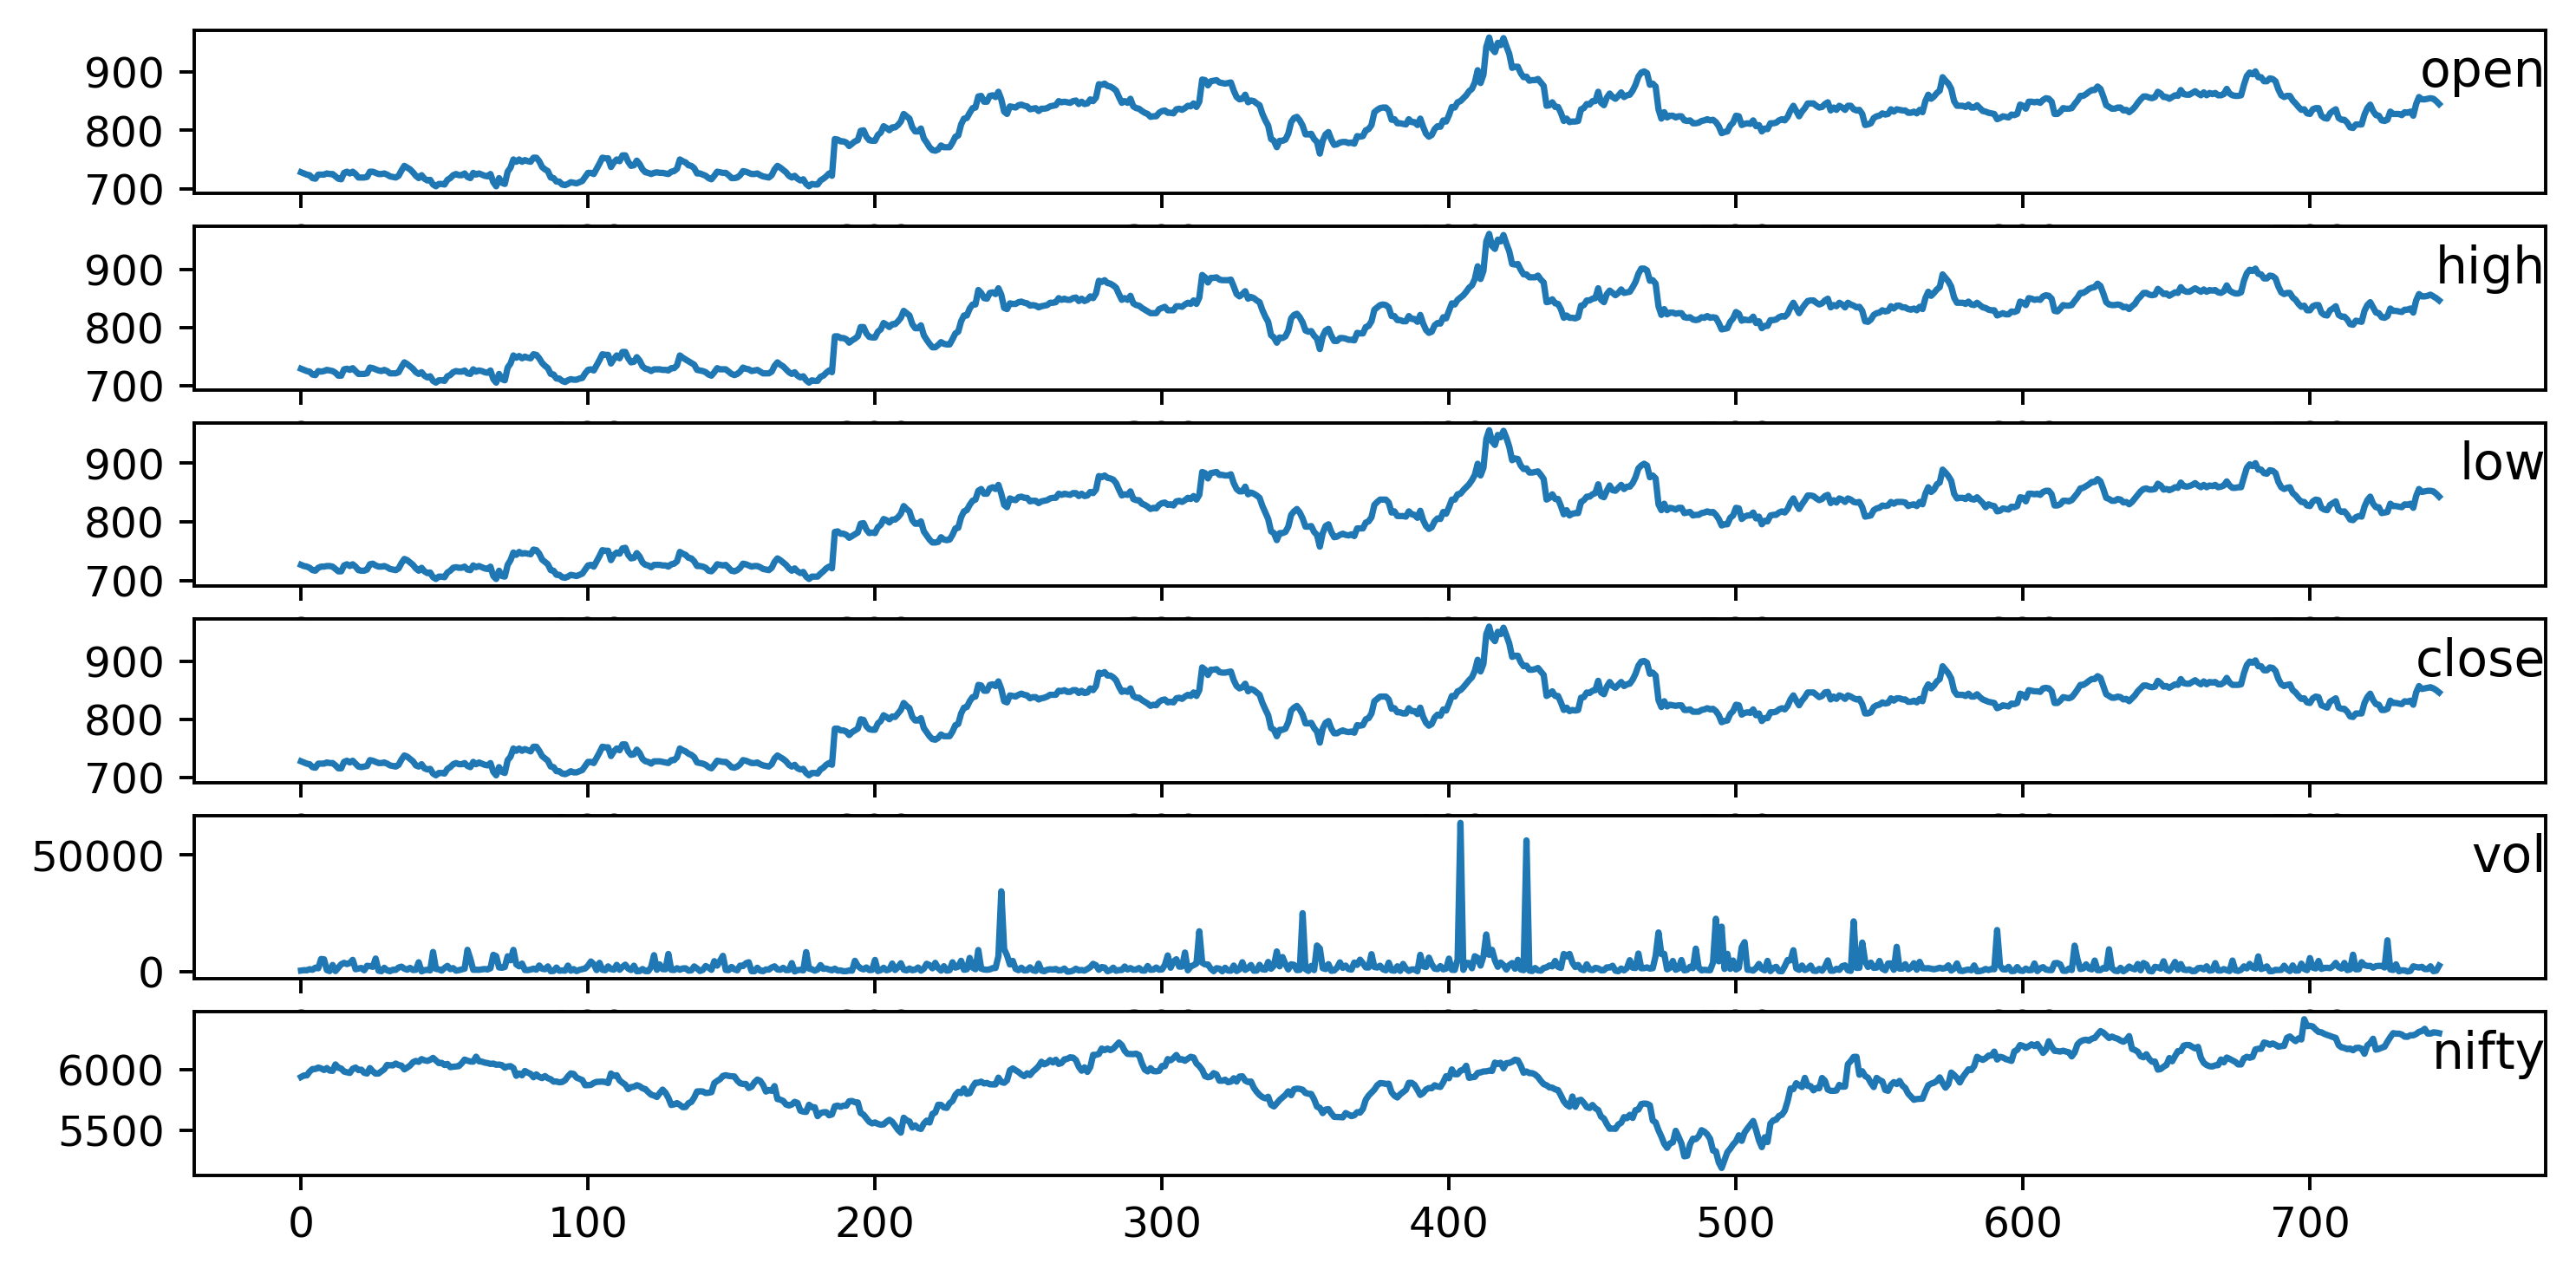

In [8]:
# load dataset
dataset = read_csv('Godrej_2013_Raw1.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure(figsize=[10.0,5.0], dpi=350)
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('Godrej_2013_Raw1.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6, 7, 8, 9, 10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var6(t)
1   0.094118   0.093385   0.094862   0.094118   0.007266   0.611563  0.622150
2   0.086275   0.085603   0.086957   0.086275   0.009855   0.622150  0.622150
3   0.078431   0.077821   0.083004   0.078431   0.008976   0.622150  0.648208
4   0.074510   0.073930   0.075099   0.074510   0.016383   0.648208  0.665309
5   0.054902   0.054475   0.059289   0.054902   0.012538   0.665309  0.665309


In [10]:
values = reframed.values
n_train_hours = 500

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 1, 6) (500,) (245, 1, 6) (245,)


Train on 500 samples, validate on 245 samples
Epoch 1/100
 - 0s - loss: 0.5212 - val_loss: 0.6531
Epoch 2/100
 - 0s - loss: 0.4646 - val_loss: 0.5792
Epoch 3/100
 - 0s - loss: 0.4075 - val_loss: 0.5021
Epoch 4/100
 - 0s - loss: 0.3502 - val_loss: 0.4218
Epoch 5/100
 - 0s - loss: 0.2944 - val_loss: 0.3400
Epoch 6/100
 - 0s - loss: 0.2427 - val_loss: 0.2592
Epoch 7/100
 - 0s - loss: 0.1992 - val_loss: 0.1867
Epoch 8/100
 - 0s - loss: 0.1762 - val_loss: 0.1402
Epoch 9/100
 - 0s - loss: 0.1660 - val_loss: 0.1215
Epoch 10/100
 - 0s - loss: 0.1590 - val_loss: 0.1160
Epoch 11/100
 - 0s - loss: 0.1522 - val_loss: 0.1166
Epoch 12/100
 - 0s - loss: 0.1457 - val_loss: 0.1202
Epoch 13/100
 - 0s - loss: 0.1401 - val_loss: 0.1241
Epoch 14/100
 - 0s - loss: 0.1349 - val_loss: 0.1275
Epoch 15/100
 - 0s - loss: 0.1298 - val_loss: 0.1295
Epoch 16/100
 - 0s - loss: 0.1250 - val_loss: 0.1295
Epoch 17/100
 - 0s - loss: 0.1201 - val_loss: 0.1280
Epoch 18/100
 - 0s - loss: 0.1150 - val_loss: 0.1264
Epoch 19/

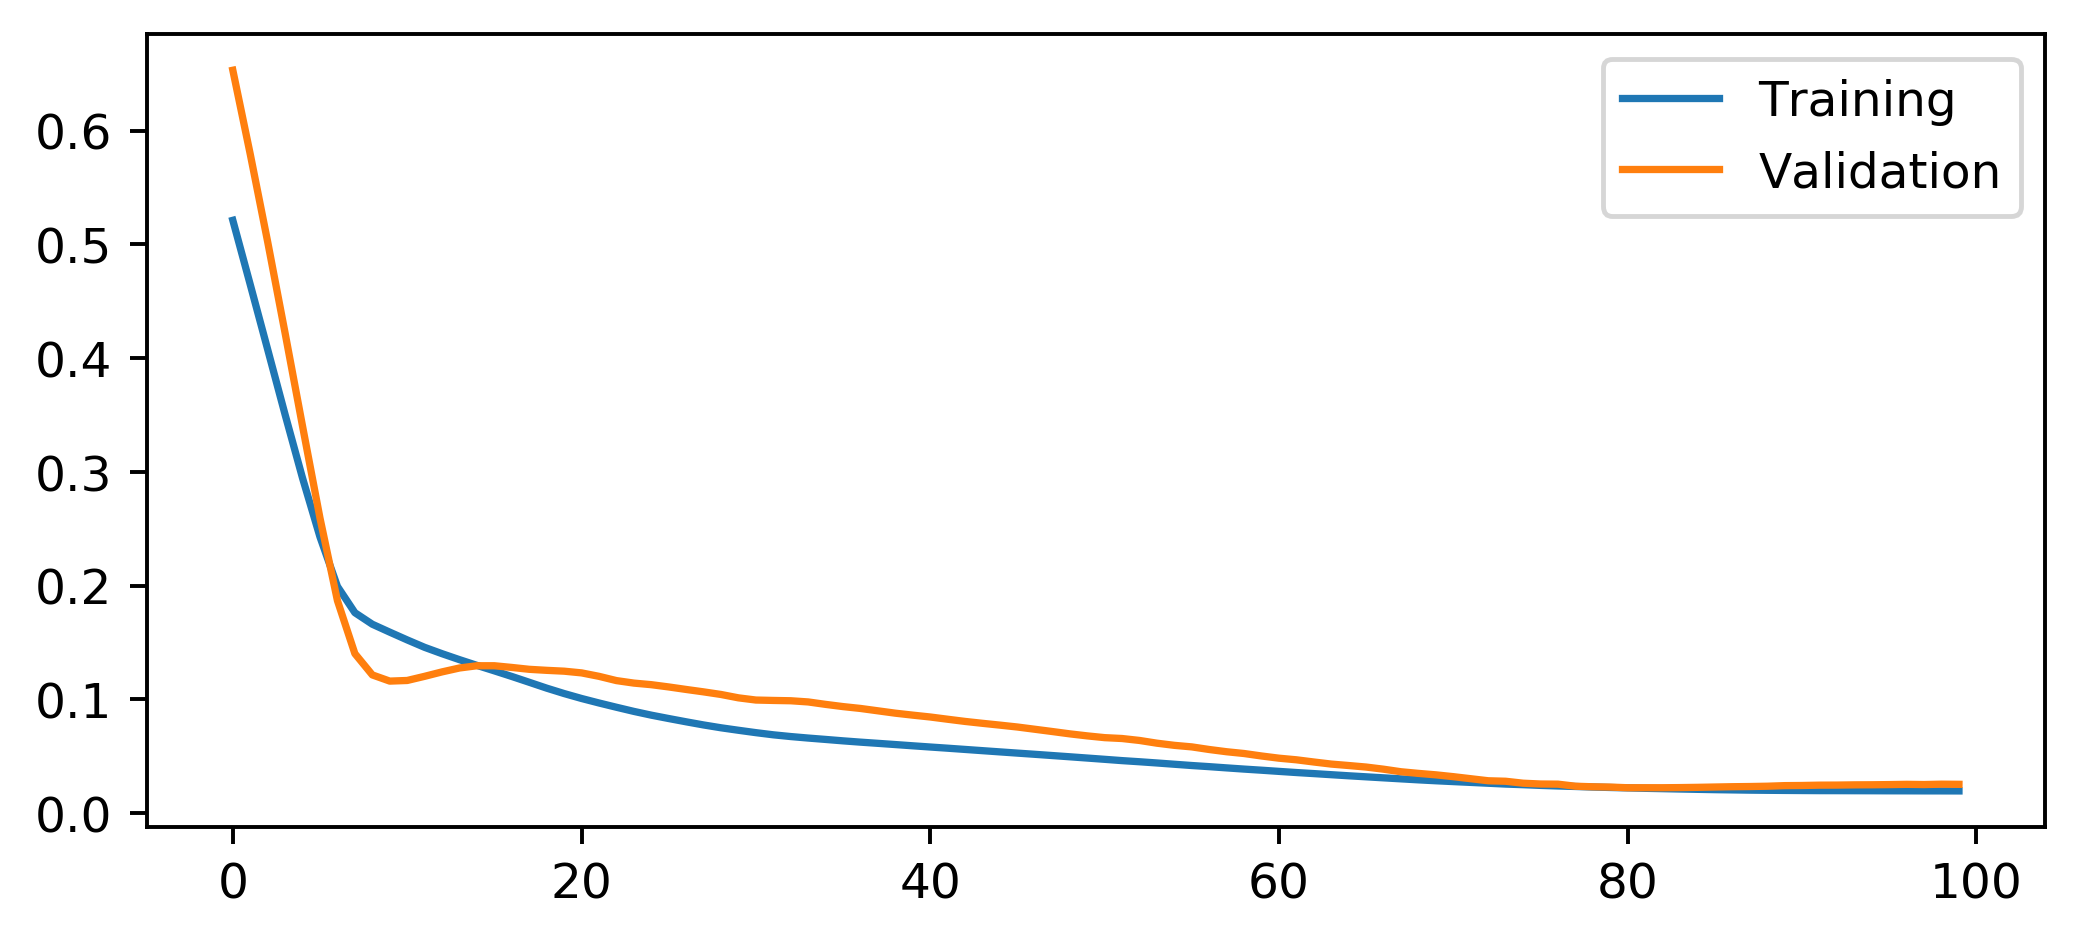

Test RMSE: 8.812
Pearsons correlation: 0.983


In [11]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=[7.0,3.0], dpi=350)
pyplot.plot(history.history['loss'], label='Training')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

corr, _ = pearsonr(inv_y, inv_yhat)
print('Pearsons correlation: %.3f' % corr)